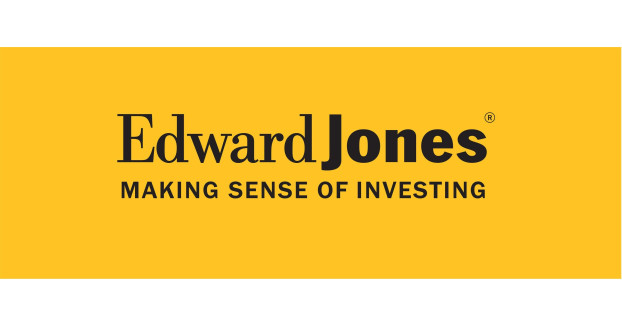

# Edward Jones Capstone Project

This Jupyter notebook is used to build a model to predict how many days it takes to submit and place a life insurance policy using the last 12 months of data on claims. This model will tell us which elements have an effect on the days to submit and will assist us in establishing service level agreements (SLA) with all the carriers.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import cross_validate

%matplotlib notebook

In [2]:
df = pd.read_csv('ASU_Team10Project_InsuranceDataset.csv', low_memory=False)

In [3]:
#Remove all the spaces within the columns of df as there are some issues
#when calling columns with spaces

col = list(df.columns)

for i in range(len(col)):
    oldstr = col[i]
    regex_2 = re.compile(r' ')
    newstr = regex_2.sub('', oldstr)
    col[i] = newstr
    
df.columns = col

In [4]:
df['InforceDate'] = pd.to_datetime(df['InforceDate'])

# Functions used to prep data

In [5]:
#Need a way to deal with columns that are categorical for use in a predictive
#model. We are going to be building a model that predicts
#Days Submitted to Final only for records that are at the stage Final-Inforce

def dum_df(df):
    df = df[df['Stage'] == 'Final - Inforce']
    #df = df[df['InforceDate'] > '3/1/2020'] #if we want to filter by pre/post covid we will include this line
    df = pd.get_dummies(df, columns=['Carrier', 'U/WType', 'PlanType', 'PlanTypeGroup', 'RiskClass', 'Interview',
                       'Exam', '1035?'], drop_first=True)
    return df

def df_timeadj(df):
    #this creates dummy variables for the month of the claim in case we want to look into trends by month
    #example: if we have a lot less claims in Feb than other months we expect shorter turnaround
    import datetime as dt
    df['InforceMonth'] = pd.DatetimeIndex(df['InforceDate']).month
    df = pd.get_dummies(df, columns=['InforceMonth'], drop_first=True)
    return df

def APS_var(df):
#create categorical variable that mentions if an APS was called. 1 for yes, 0 for no
# this is different than the # of APS. Currently not working correctly once put in a function
    df['APS_Yes'] = 0

    for i in df.index:
        if df['#ofAPS?'].loc[i] > 0:
            df['APS_Yes'].loc[i] = 1
        else:
            df['APS_Yes'].loc[i] = 0
        return df
          

def col_clean(df):
#Remove all the spaces within the columns of df as there are some issues to avoid any potential issues
#when calling columns with spaces

    col = list(df.columns)

    for i in range(len(col)):
        oldstr = col[i]
        regex_2 = re.compile(r' ')
        newstr = regex_2.sub('', oldstr)
        col[i] = newstr
    
    df.columns = col
    return df

def combine_UW(df):
    #need clarification from Devon on why we did this again
    df['U/WCombined'] = df['U/WType_FullUnderwriting'] + df['U/WType_ReducedUnderwriting']
    df.drop(['U/WType_FullUnderwriting', 'U/WType_ReducedUnderwriting'], axis=1, inplace=True)
    return df

def df_clean(df, col):
    #create a dataframe of absolute value of correlations which will be used to identify variables
    #for our model building process
    tx = pd.DataFrame(abs(df.corrwith(df[col])))
    new_lst = list()
    threshold = .1
    #for loop that iterates through each absolute value of correlation and
    #saves it to new_list if above certain threshold defined above
    for i in range(len(tx)-1):
        if tx.loc[tx.index[i+1]][0] > threshold:
            new_lst.append(tx.index[i+1])
    
    new_df = df[new_lst]
    #if the features in drop_val exist in new_df we drop them. We won't
    #have these values when we gain new applications
    drop_val = ['DaysinUnderwriting', 'DaysinApproval', 'DaysinIssued']
    new_col = []
    for i in new_df.columns:
        if i not in drop_val:
            new_col.append(i)
        
    new_df = new_df[new_col]
    return new_df

def data_clean_funcs(df):
    #this function iterates through all steps to make it a quick process to format our data
    df = dum_df(df)
    df.reset_index(drop=True, inplace=True)
    df = df_timeadj(df)
#     df = col_clean(df)
#     df = combine_UW(df)
#     df = APS_var(df)
    return df

In [6]:
#seems to be an issue with the APS_Yes function. Need to fix this issue before moving forward

df = data_clean_funcs(df)
df

,Policy#,TermDuration(Yrs),Benefit,Stage,SubmittedDate,DaysinSubmitted,UnderwritingDate,DaysinUnderwriting,ApprovalDate,DaysinApproval,...,InforceMonth_3,InforceMonth_4,InforceMonth_5,InforceMonth_6,InforceMonth_7,InforceMonth_8,InforceMonth_9,InforceMonth_10,InforceMonth_11,InforceMonth_12
0,1,10,500000.0,Final - Inforce,12/10/2019,0,12/10/2019,2,NaN,0,...,0,0,0,0,0,0,0,0,0,1
1,2,20,250000.0,Final - Inforce,11/25/2019,1,11/26/2019,1,NaN,0,...,0,0,0,0,0,0,0,0,1,0
2,3,NaN,6000000.0,Final - Inforce,2/26/2020,0,2/26/2020,1,NaN,0,...,0,0,0,0,0,0,0,0,0,0
3,4,15,750000.0,Final - Inforce,6/8/2020,0,6/8/2020,1,NaN,0,...,0,0,0,1,0,0,0,0,0,0
4,5,10,750000.0,Final - Inforce,2/12/2020,0,2/12/2020,1,2/13/2020,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50951,50952,15,400000.0,Final - Inforce,3/11/2019,1,3/12/2019,394,4/9/2020,14,...,0,0,1,0,0,0,0,0,0,0
50952,50953,30,1000000.0,Final - Inforce,2/25/2019,1,2/26/2019,234,10/18/2019,125,...,0,0,1,0,0,0,0,0,0,0
50953,50954,10,500000.0,Final - Inforce,5/15/2019,1,5/16/2019,446,NaN,0,...,0,0,0,0,0,1,0,0,0,0
50954,50955,NaN,496500.0,Final - Inforce,5/9/2019,0,5/9/2019,335,4/8/2020,120,...,0,0,0,0,0,1,0,0,0,0


In [7]:
df['#ofAPS?']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
50951    1.0
50952    1.0
50953    8.0
50954    3.0
50955    0.0
Name: #ofAPS?, Length: 50956, dtype: float64

In [ ]:
df = df.copy()
df['APS_Yes'] = 0

for i in df.index:
    if df['#ofAPS?'].loc[i] > 0:
        df['APS_Yes'].loc[i] = 1
    else:
        df['APS_Yes'].loc[i] = 0

In [ ]:
df['APS_Yes'].value_counts()

# Exploratory Analysis

In [ ]:
#Can run this code to generate the average number of days submitted to final by company for dates
#Can swap out carrier name and date. For carrier A, we need to set all carriers equal to 0

df[(df['Carrier_CompanyB'] == 1) & (df['InforceDate'] < '3/1/2020')]['DaysSubmittedtoFinal'].mean()
#df[(df['Carrier_CompanyC'] == 1) & (df['InforceDate'] < '3/1/2020')]['DaysSubmittedtoFinal'].mean()
#df[(df['Carrier_CompanyD'] == 1) & (df['InforceDate'] < '3/1/2020')]['DaysSubmittedtoFinal'].mean()
#df[(df['Carrier_CompanyE'] == 1) & (df['InforceDate'] < '3/1/2020')]['DaysSubmittedtoFinal'].mean()
#df[(df['Carrier_CompanyF'] == 1) & (df['InforceDate'] < '3/1/2020')]['DaysSubmittedtoFinal'].mean()
#df[(df['Carrier_CompanyB'] == 0) & (df['InforceDate'] < '3/1/2020') & (df['Carrier_CompanyC'] == 0) & (df['Carrier_CompanyD'] == 0) & (df['Carrier_CompanyE'] == 0) & (df['Carrier_CompanyF'] == 0)]['DaysSubmittedtoFinal'].mean()



### Average Days Submitted to Final by Carrier Companies

Average Days Submitted to Final by Company after March 1st:
- Company A: 57.33 days
- Company B: 75.91 days
- Company C: 102.28 days
- Company D: 75.70 days
- Company E: 73.06 days
- Company F: 75.47 days

Average Days Submitted to Final by Company before March 1st:
- Company A: 67.57 days
- Company B: 75.93 days
- Company C: 99.69 days
- Company D: 72.13 days
- Company E: 78.14 days
- Company F: 73.87 days

In [ ]:
#Next thing we wanted to understand was the frequency of claims over the months

df[(df['InforceMonth_2'] == 0) & (df['InforceMonth_3'] == 0) & (df['InforceMonth_4'] == 0) & (df['InforceMonth_5'] == 0) & (df['InforceMonth_6'] == 0) & (df['InforceMonth_7'] == 0) & (df['InforceMonth_8'] == 0) & (df['InforceMonth_9'] == 0) & (df['InforceMonth_10'] == 0) & (df['InforceMonth_11'] == 0) & (df['InforceMonth_12'] == 0)]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_2'] == 1]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_3'] == 1]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_4'] == 1]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_5'] == 1]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_6'] == 1]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_7'] == 1]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_8'] == 1]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_9'] == 1]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_10'] == 1]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_11'] == 1]['DaysSubmittedtoFinal'].count()
#df[df['InforceMonth_12'] == 1]['DaysSubmittedtoFinal'].count()

### Frequency of Claims by Month

- Jan: 4,285
- Feb: 4,143
- March: 4,434
- April: 4,643
- May: 3,714
- June: 3,880
- July: 3,750
- August: 3,426
- September: 4,183
- October: 4,873
- November: 4,145
- December: 5,480

Seems to be summer is a little lighter and it gets busier towards the end of the year. 

In [ ]:
sns.distplot(df['DaysSubmittedtoFinal'])

In [ ]:
#Looks like we may have some outliers by looking at the max value here. Will need to evaluate futher

df['DaysSubmittedtoFinal'].describe()

In [ ]:
df[df['DaysSubmittedtoFinal'] > (df['DaysSubmittedtoFinal'].mean() + (3*df['DaysSubmittedtoFinal'].std()))]

In [ ]:
#After noticing the variation among the companies, we have decided to
#look at removing carrier companies A and C to get a more accurate 
#model. This creates a new dataframe by removing these companies

df = df[(df['Carrier_CompanyB'] == 1) | (df['Carrier_CompanyD'] == 1) | (df['Carrier_CompanyE'] == 1) | (df['Carrier_CompanyF'] == 1)]

In [ ]:
df[df['APS_Yes'] == 1]

#issue with new version here that is not saving 1 values. Need to address

# Preprocessing

In [ ]:
from sklearn import preprocessing

dsf = df['DaysSubmittedtoFinal']
dsf = pd.DataFrame(dsf)


dsf = preprocessing.scale(dsf)
dsf = pd.DataFrame(dsf)

In [ ]:
import seaborn as sns
sns.distplot(dsf, bins=15)

In [ ]:
keep_val = dsf[(dsf[0] <= 3) & (dsf[0] >= -3)].index
keepdf = pd.DataFrame(keep_val)
keepdf[0]
df = pd.DataFrame(df.iloc[keepdf[0]])      
df.reset_index(drop=True, inplace=True)
df

In [ ]:
df = df[df.columns.drop(list(df.filter(regex='Date')))]

In [ ]:
df = df.copy()
df.drop(['Stage', 'ProcessingType'], axis=1, inplace=True)

In [ ]:
#Making sure that we have removed the whitespace in column names and
#we don't have multiple column names for dummy value columns with only 2
#values
for i in df.columns:
    print(i)

In [ ]:
def df_clean(df, col):
    #create a dataframe of absolute value of correlations
    tx = pd.DataFrame(abs(df.corrwith(df[col])))
    new_lst = list()
    threshold = .1
    #for loop that iterates through each absolute value of correlation and
    #saves it to new_list if above certain threshold defined above
    for i in range(len(tx)-1):
        if tx.loc[tx.index[i+1]][0] > threshold:
            new_lst.append(tx.index[i+1])
    
    new_df = df[new_lst]
    #if the features in drop_val exist in new_df we drop them. We won't
    #have these values when we gain new applications
    drop_val = ['DaysinUnderwriting', 'DaysinApproval', 'DaysinIssued']
    new_col = []
    for i in new_df.columns:
        if i not in drop_val:
            new_col.append(i)
        
    new_df = new_df[new_col]
    return new_df

In [ ]:
new_df = df_clean(df, 'DaysSubmittedtoFinal')

In [ ]:
df.corrwith(df['DaysSubmittedtoFinal'])

In [ ]:
#There are null values in Insured Age and we will need to deal with this

for i in new_df:
    print(new_df[i].isna().value_counts())

In [ ]:
from sklearn.impute import SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='median')
age = pd.DataFrame(new_df['InsuredAge'])
agedf = pd.DataFrame(si.fit_transform(age), index=new_df.index)

In [ ]:
new_df['InsuredAge'] = agedf

# Building and Evaluating Models

In [ ]:
#split our dataframe into x and y for use in machine learning

x = new_df.drop('DaysSubmittedtoFinal', axis=1)
y = new_df['DaysSubmittedtoFinal']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

#Linear Regression
from sklearn.linear_model import LinearRegression
li = LinearRegression()
param_gridLin = {#'fit_intercept': (True, False),
              'normalize': (True, False),
              'copy_X': (True, False)}
gsLin = GridSearchCV(li, param_gridLin, cv=5)
gsLin.fit(x_train, y_train)
y_Lin = gsLin.predict(x_test)

#DecisionTree Regressor
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor()
param_gridDT = {'splitter': ('best', 'random'),
             'max_depth': (None, 20, 40, 60),
             'max_features': ('auto', 'sqrt', 'log2', None)}
gsDT = GridSearchCV(dtreg, param_gridDT, cv=5)
gsDT.fit(x_train, y_train)
y_dt = gsDT.predict(x_test)


#Nearest Neighbors Regression
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor()
param_gridkn = {'n_neighbors': (3,5,7,9), 
               'weights': ('uniform', 'distance'),
               'algorithm': ('auto', 'ball_tree', 'kd_tree', 
                            'brute')}
gsKN = GridSearchCV(knr, param_gridkn, cv=5)
gsKN.fit(x_train, y_train)
y_KN = gsKN.predict(x_test)

In [ ]:
scores = cross_validate(gsLin, x_train, y_train, cv=5, return_train_score=False)
scores['test_score'].mean()

In [ ]:
scores = cross_validate(gsDT, x_train, y_train, cv=5, return_train_score=False)
scores['test_score'].mean()

In [ ]:
scores = cross_validate(gsKN, x_train, y_train, cv=5, return_train_score=False)
scores['test_score'].mean()

In [ ]:
residuals = y_test - y_Lin
residuals.reset_index(drop=True)

In [ ]:
import seaborn as sns
plt.figure(figsize=(11,11))
fig = sns.residplot(y_test, y_Lin)

In [ ]:
residuals.mean()

In [ ]:
residuals.std()

In [ ]:
residuals.mean() + (2*residuals.std())

In [ ]:
residuals.mean() - (2*residuals.std())

In [ ]:
residuals = pd.DataFrame(residuals)

In [ ]:
y_Lin.max()

In [ ]:
new_df['DaysSubmittedtoFinal'].std()

## Predicted Days Submitted to Final Stats:
min - 22.82 days
max - 235.69 days
avg - 71.96
std - 20.94 days

## Actual Days Submitted to Final Stats:
min - 2 days
max - 212 days
mean - 72.07 days
std - 39.13 days